In [2]:
from qiskit import Aer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import SpinMapper, DirectMapper, LinearMapper, JordanWignerMapper
from qiskit.opflow import X, Z, I
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

import pylab
import numpy as np
import retworkx as rx
from qiskit_nature.problems.second_quantization.lattice import (
    BoundaryCondition,
    IsingModel,
    FermiHubbardModel,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

In [3]:
from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal

tl_circuit = TwoLocal(
    rotation_blocks=["h", "rx"],
    entanglement_blocks="cz",
    entanglement="full",
    reps=2,
    parameter_prefix="y",
)

vqe_solver = VQE(
    ansatz=tl_circuit,
    quantum_instance=QuantumInstance(Aer.get_backend("aer_simulator_statevector")),
)

In [76]:
#Locally Coupled
def convertSpin(ham):
    result = None
    for c, x, z in zip(ham._coeffs, ham.x, ham.z):
        if 1 in x:
            pauli_x = X if x[0] == 1 else I
            for n in range(1, ham.register_length):
                pauli_x ^= X if x[n] == 1 else I
            pauli_x *= c
            result = result + pauli_x if result else pauli_x

        if 1 in z:
            pauli_z = Z if z[0] == 1 else I
            for n in range(1, ham.register_length):
                pauli_z ^= Z if z[n] == 1 else I
            pauli_z *= 1
            result = result + pauli_z if result else pauli_z
    return result

def makeLatticeIsing(size):
    lattice = LineLattice(size, boundary_condition=BoundaryCondition.PERIODIC)

    t = -1.0  # the interaction parameter
    v = 1.0  # the onsite potential

    ising = IsingModel.uniform_parameters(
        lattice=lattice,
        uniform_interaction=t, #interaction strength -- "hopping term"
        uniform_onsite_potential=v
    )
    return convertSpin(ising.second_q_ops())
print(makeLatticeIsing(3))

1.0 * ZZI
+ 1.0 * IZZ
+ 1.0 * XII
+ 1.0 * IXI
+ 1.0 * IIX
+ 1.0 * ZIZ


In [77]:
#Example of Data
latticeIsing = makeLatticeIsing(2)
print("lattice:\n", latticeIsing)
result = vqe_solver.compute_minimum_eigenvalue(latticeIsing)
print(result)
type(type(result))

lattice:
 1.0 * ZZ
+ 1.0 * XI
+ 1.0 * IX
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 58,
    'eigenstate': array([-7.35766399e-05+5.59500955e-05j,  6.04861959e-01+7.95417955e-01j,
       -2.30673006e-02-3.03344338e-02j, -2.14286254e-05+1.62950311e-05j]),
    'eigenvalue': (-0.9999999814627017+0j),
    'optimal_parameters': {   ParameterVectorElement(y[4]): -3.5670065305457452,
                              ParameterVectorElement(y[0]): 5.570382326190403,
                              ParameterVectorElement(y[2]): -3.3246802890184806,
                              ParameterVectorElement(y[1]): -4.270092770189872,
                              ParameterVectorElement(y[3]): -0.43159566353793793,
                              ParameterVectorElement(y[5]): 3.308154142853507},
    'optimal_point': array([ 5.57038233, -4.27009277, -3.32468029, -0.43159566, -3.56700653,
        3.30815414]),
    'optimal_value': -0.9999999814627017,
    'optimizer_evals': None,
    'optimi

abc.ABCMeta

In [78]:
latticeResults = []
minResults = {}
minEigenvalues = {}

In [5]:
n = 10
def findMin(r):
    groundStates = {}
    results = {}
    for _ in range(r):
        for i in range(1, n):
            ising = makeLatticeIsing(i)
            if ising:
                result = vqe_solver.compute_minimum_eigenvalue(ising)
                if result.eigenvalue < groundStates.get(i, float('inf')):
                    results[i] = result
                    groundStates[i] = result.eigenvalue
                    print(f"Minimum {i:<5}: {result.eigenvalue}")
                else:
                    print(f"Processed {i}")
    return results, groundStates

results, groundStates = findMin(10)

Minimum 1    : (-1+0j)
Minimum 2    : (-0.9999999100196753+0j)
Minimum 3    : (-0.9999999173394872+0j)
Minimum 4    : (-3.9999999408396407+0j)
Minimum 5    : (-2.999999624766234+0j)
Minimum 6    : (-1.9999999795333714+0j)
Minimum 7    : (-4.999999704940084+0j)
Minimum 8    : (-7.999999958192163+0j)
Minimum 9    : (-6.999999806101146+0j)
Processed 1
Processed 2
Processed 3
Minimum 4    : (-3.9999999952336087+0j)
Minimum 5    : (-2.9999999153140826+0j)
Minimum 6    : (-5.999999820144581+0j)
Minimum 7    : (-4.999999860585964+0j)
Processed 8
Processed 9
Processed 1
Minimum 2    : (-0.999999999468624+0j)
Processed 3
Processed 4
Minimum 5    : (-2.999999993076121+0j)
Processed 6
Processed 7
Processed 8
Processed 9
Processed 1
Processed 2
Minimum 3    : (-0.9999999409549815+0j)
Processed 4
Processed 5
Processed 6
Minimum 7    : (-4.9999999855087225+0j)
Processed 8
Minimum 9    : (-6.999999972053235+0j)
Processed 1
Minimum 2    : (-0.9999999995837952+0j)
Minimum 3    : (-0.9999999877027697+0j

Text(0.5, 1.0, 'Ground State Energy')

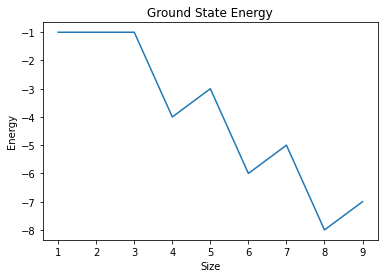

In [98]:
pylab.plot(groundStates.keys(), groundStates.values(), label='local')
pylab.xlabel('Size')
pylab.ylabel('Energy')
pylab.title('Ground State Energy')

Text(0.5, 1.0, 'Optimizer Times')

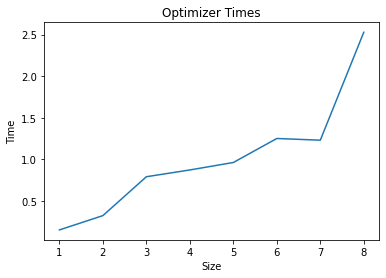

In [39]:
latticeTimes = [r.optimizer_time for r in latticeResults]
pylab.plot(minEigenvalues.keys(), latticeTimes, label='local')

pylab.xlabel('Size')
pylab.ylabel('Time')
pylab.title('Optimizer Times')